In [51]:
%run ../src/path.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [386]:
data = pd.read_excel(TRANSFORMED_DATA_DIR / 'data_transformed.xlsx')
data = data.rename(columns={'Nivel Sol. Libre cm':'Nivel'})
data.head(2)

,Fecha,NaNO3,K,MgL,Nivel,Flujo salida,Ley bandeja %NaNO3,Temperatura,Semana,dia,mes,Sat calculada,Sat semanal
0,2022-01-01,432,50,20.070085,NaN,6574.0,3.0,29.866071,52,1,1,448.000000,448.0
1,2022-01-02,430,50,19.984615,NaN,6579.0,4.9,28.098958,52,2,1,449.333333,448.0


In [387]:
data.columns

Index(['Fecha', 'NaNO3', 'K', 'MgL', 'Nivel', 'Flujo salida',
       'Ley bandeja %NaNO3', 'Temperatura', 'Semana', 'dia', 'mes',
       'Sat calculada', 'Sat semanal'],
      dtype='object')

In [388]:
data[data['Nivel']=='SinSol']['Nivel Sol. Libre cm'] = None


C:\Users\FeZuniga\AppData\Local\Temp\ipykernel_23236\2300086530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['Nivel']=='SinSol']['Nivel Sol. Libre cm'] = None


In [406]:
data['Nivel'][data['Nivel']=='SinSol'] = None

C:\Users\FeZuniga\AppData\Local\Temp\ipykernel_23236\2417507687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Nivel'][data['Nivel']=='SinSol'] = None


In [408]:
data['precipitacion'] = np.where(data['Ley bandeja %NaNO3']>10, 1,0)
data['NaNO3/K'] = np.where( data['K'] !=0, data['NaNO3'] / data['K'], None)
data['NaNO3/K'] = data['NaNO3/K'].astype(float)
data['NaNO3/K'] = data['NaNO3/K'].interpolate()
data['Nivel'] = data['Nivel'].astype(float)

In [353]:
numeric_features = ['NaNO3', 'K', 'MgL', 'Flujo salida','Temperatura']
categorical_features = ['dia', 'mes','Sat semanal']

In [354]:
df_precip = data[data['Ley bandeja %NaNO3']>10]

In [409]:
X = data[['NaNO3', 'K', 'MgL', 'Flujo salida','Temperatura', 'Semana', 'dia', 'mes','NaNO3/K', 'Nivel']]
y = data['Ley bandeja %NaNO3']

In [294]:
# train_size = int(len(data) * 0.8)

# train_data, test_data = data[:train_size], data[train_size:]

In [410]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
model = XGBRegressor().fit(X_train,y_train)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor().fit(X_train,y_train)


In [297]:
data.shape, X_train.shape, y_train.shape, X_test.shape

((768, 14), (614, 8), (614,), (154, 8))

MSE: 736.1776165939585
RMSE_train: 0.2463516168361069
RMSE: 27.132593252285314
R2: -16.936805117612835


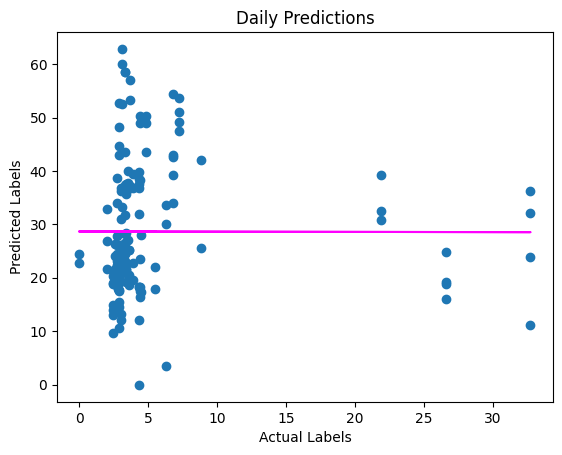

In [412]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("MSE:", mse)
print("RMSE_train:", rmse_train)
print("RMSE:", rmse)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [413]:
pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Feature'])

,Feature
NaNO3,0.029291
K,0.041275
MgL,0.030856
Flujo salida,0.038856
Temperatura,0.059934
Semana,0.177727
dia,0.016481
mes,0.561945
NaNO3/K,0.014502
Nivel,0.029134


In [277]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 50} 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 

MSE: 489.0064863300186
RMSE: 22.11349104800096
R2: -10.914535091587746


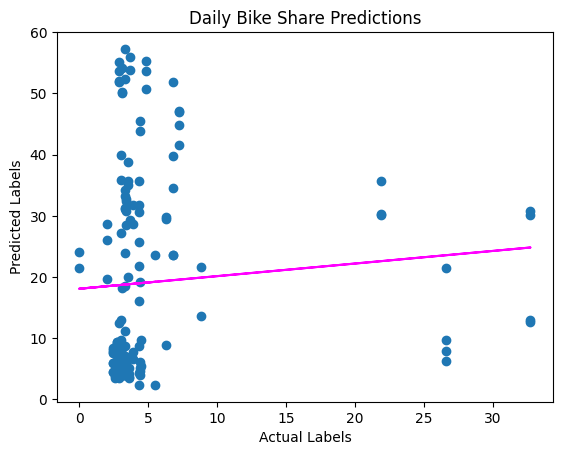

In [278]:
alg = XGBRegressor()

params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [102]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [113]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [114]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])

In [115]:
model = pipeline.fit(X_train, y_train)

In [207]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [414]:
df = data.copy()

In [415]:
def add_lags(df):
    df['Lag1'] = df['Ley bandeja %NaNO3'].shift(1)
    df['Lag2'] = df['Ley bandeja %NaNO3'].shift(7)
    df['Lag3'] = df['Ley bandeja %NaNO3'].shift(14)

    return df


In [416]:
df = add_lags(df)

In [417]:
df.columns

Index(['Fecha', 'NaNO3', 'K', 'MgL', 'Nivel', 'Flujo salida',
       'Ley bandeja %NaNO3', 'Temperatura', 'Semana', 'dia', 'mes',
       'Sat calculada', 'Sat semanal', 'precipitacion', 'NaNO3/K', 'Lag1',
       'Lag2', 'Lag3'],
      dtype='object')

In [423]:
X = df[['NaNO3', 'K', 'MgL', 'Flujo salida','Temperatura', 'Semana', 'dia', 'mes','Nivel','Lag2','Lag3']]
y = df['Ley bandeja %NaNO3']

In [424]:
X.head(2)

,NaNO3,K,MgL,Flujo salida,Temperatura,Semana,dia,mes,Nivel,Lag2,Lag3
0,432,50,20.070085,6574.0,29.866071,52,1,1,NaN,NaN,NaN
1,430,50,19.984615,6579.0,28.098958,52,2,1,NaN,NaN,NaN


In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

model = XGBRegressor(reg_alpha=10, reg_lambda=0.001).fit(X_train,y_train)

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor().fit(X_train,y_train)


MSE: 137.35036835733493
RMSE_train: 1.0450771308985767
RMSE: 11.71965734811965
R2: -2.3465114050277838


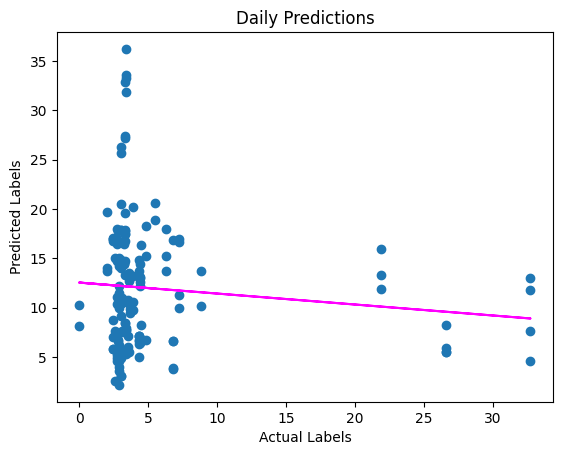

In [428]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("MSE:", mse)
print("RMSE_train:", rmse_train)
print("RMSE:", rmse)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [429]:
pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Feature'])

,Feature
NaNO3,0.099345
K,0.075502
MgL,0.064326
Flujo salida,0.033909
Temperatura,0.026683
Semana,0.068951
dia,0.015867
mes,0.001196
Nivel,0.064321
Lag2,0.452049


In [430]:
residuals = y_test - predictions

<Axes: ylabel='Ley bandeja %NaNO3'>

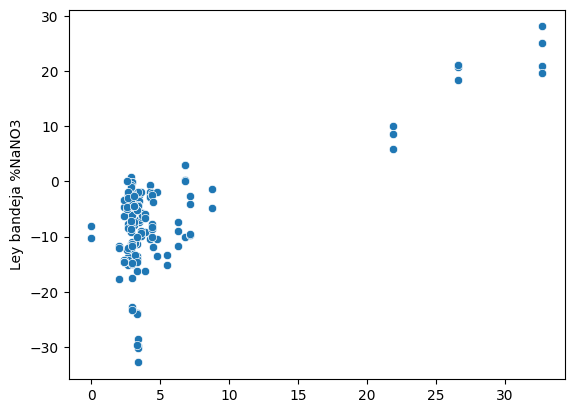

In [431]:
sns.scatterplot(x=y_test.values, y=residuals)

<Axes: >

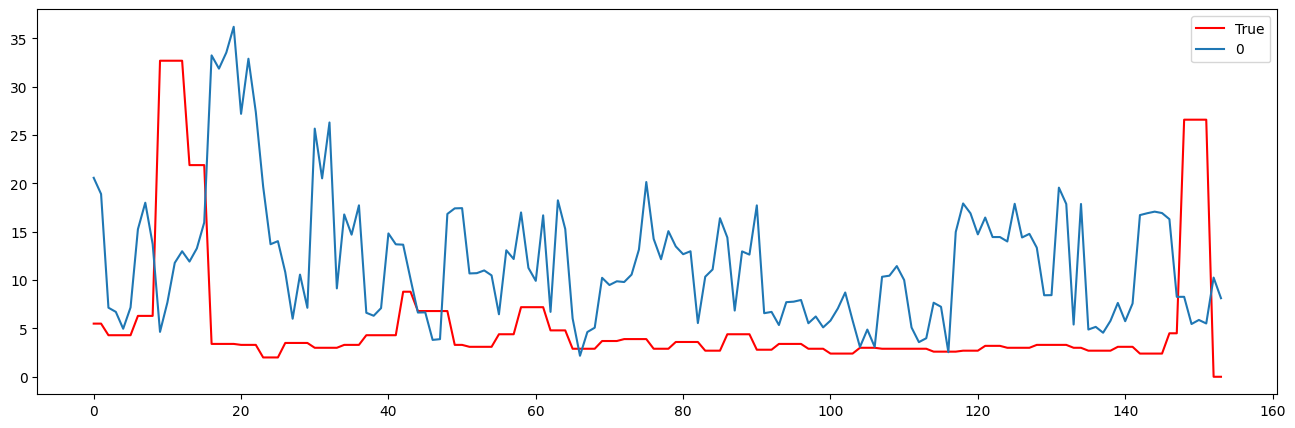

In [461]:
plt.figure(figsize=(16,5))
y_test.reset_index(drop=True).plot(label='True',color='red')
sns.lineplot(pd.DataFrame(predictions))


In [432]:
residuals

614   -15.086401
615   -13.407423
616    -2.847682
617    -2.415464
618    -0.669882
         ...    
763    21.140767
764    20.720812
765    21.084992
766   -10.263021
767    -8.130127
Name: Ley bandeja %NaNO3, Length: 154, dtype: float64

<Axes: >

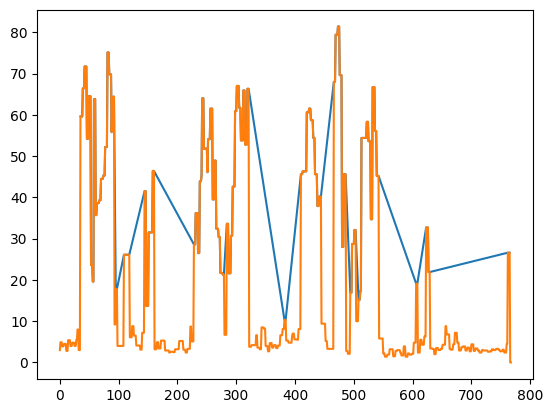

In [311]:
df[df['Ley bandeja %NaNO3']>10]['Ley bandeja %NaNO3'].plot()
df['Ley bandeja %NaNO3'].plot()

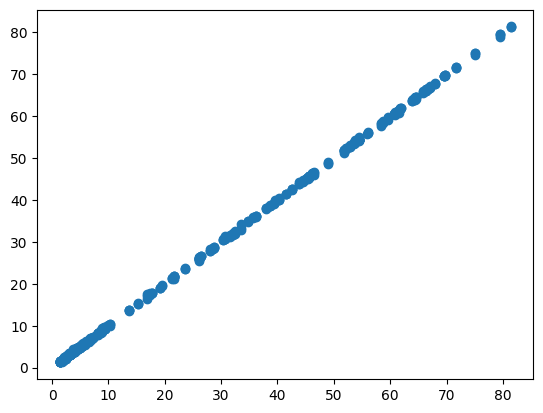

In [323]:
train_pred = model.predict(X_train)
plt.scatter(y_train, train_pred)
# y_train.values